In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.abspath(''))
import numpy as np
import pandas as pd
import geopandas as gpd
from geo import COM, PROV, REG, DEMOG

import matplotlib.pyplot as plt
%matplotlib notebook

def datech(s):
    return f'{s[6:]}-{s[4:6]}-{s[0:4]}'

In [2]:
CWD = Path(os.path.abspath(''))

data_dir = CWD / 'protezione_civile/COVID-19'
prov_dir = data_dir /  'dati-province'

In [3]:
DEMOG[['prov_name', 'population']].groupby('prov_name').sum().query('prov_name=="roma"')
DEMOG.query('prov_name=="roma" and Sesso=="totale"')
pop = DEMOG.pivot_table(index=['prov_name'], columns=['Sesso', 'Stato civile', 'Età'])['population']['totale']['totale'][['totale']].reset_index()
prov = PROV.merge(pop, on='prov_name')
#prov.plot('totale', legend=True)
#plt.title('Residenti al primo Gennaio 2020')

# Dati della Protezione Civile
Data from [github.com/pcm-dpc/COVID-19](https://github.com/pcm-dpc/COVID-19).

Questi dati sono da aggiornare giornalmente coi comandi:
```
cd covid-19/protezione_civile/COVID-19
git fetch
git merge
```

## Province

In [4]:
df = []
prec = lambda s: f'{s:.4f}'
for f in sorted(prov_dir.glob('dpc-covid19-ita-province-2020*.csv')):
    tmp_df = pd.read_csv(f, encoding='latin-1')
    tmp_df['day'] = str(f).split('/')[-1].split('-')[-1].rstrip('.csv')
    tmp_df['geometry'] = gpd.points_from_xy(tmp_df['long'], tmp_df['lat'])
    tmp_df['lat_long'] = tmp_df['lat'].apply(prec).astype(str) + '_' + tmp_df['long'].apply(prec).astype(str)
    df.append(tmp_df)
    del tmp_df
DF = pd.concat(df)

df = DF.pivot_table(index='sigla_provincia', columns='day', values='totale_casi')
dates = [_ for _ in df.columns if '20' in _]
df['totale_casi'] = df.sum(1)
df['nuovi_casi'] = df[dates[-1]] - df[dates[-2]]

In [5]:
m = prov.merge(df, left_on='prov_acr', right_on='sigla_provincia')
tocsv = pd.DataFrame(m.drop(columns=['geometry', 'prov_istat_code_num', 'reg_istat_code', 'reg_istat_code_num', 'prov_istat_code']))
m['casi_100k'] = m['totale_casi'] / m['totale'] * 100000
m['nuovi_casi_100k'] = m['nuovi_casi'] / m['totale'] * 100000
m['var_perc_1day'] = 100 * (m[dates[-1]] - m[dates[-2]]) / m[dates[-2]]

In [6]:
tocsv.rename(mapper={'totale': 'residenti'}, axis=1).to_csv('csv/andamento_province.csv', index=False)

<IPython.core.display.Javascript object>


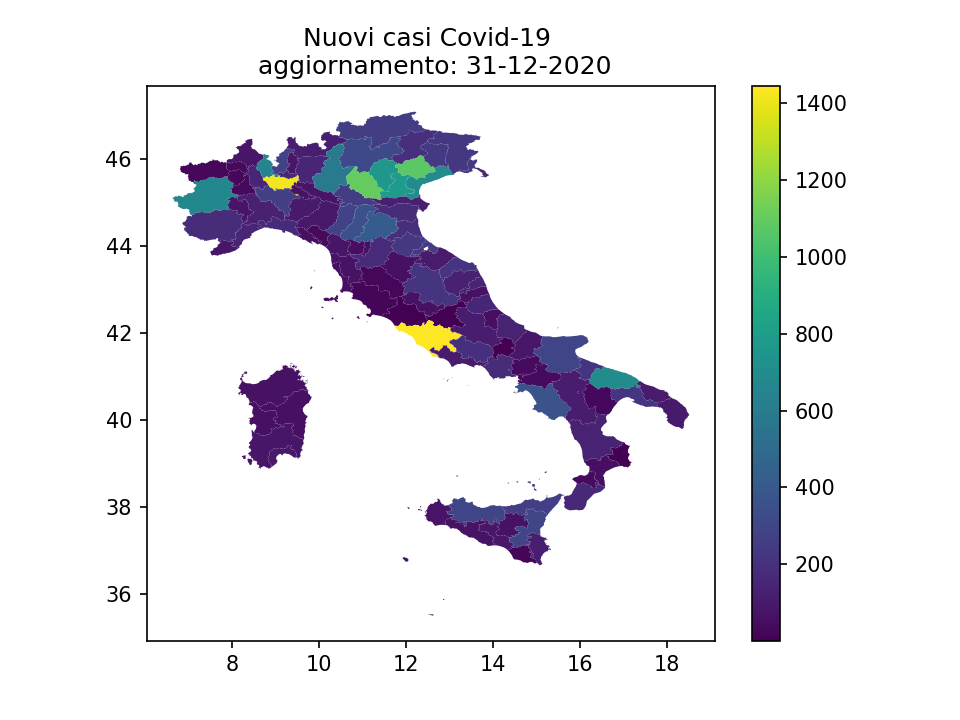

<IPython.core.display.Javascript object>


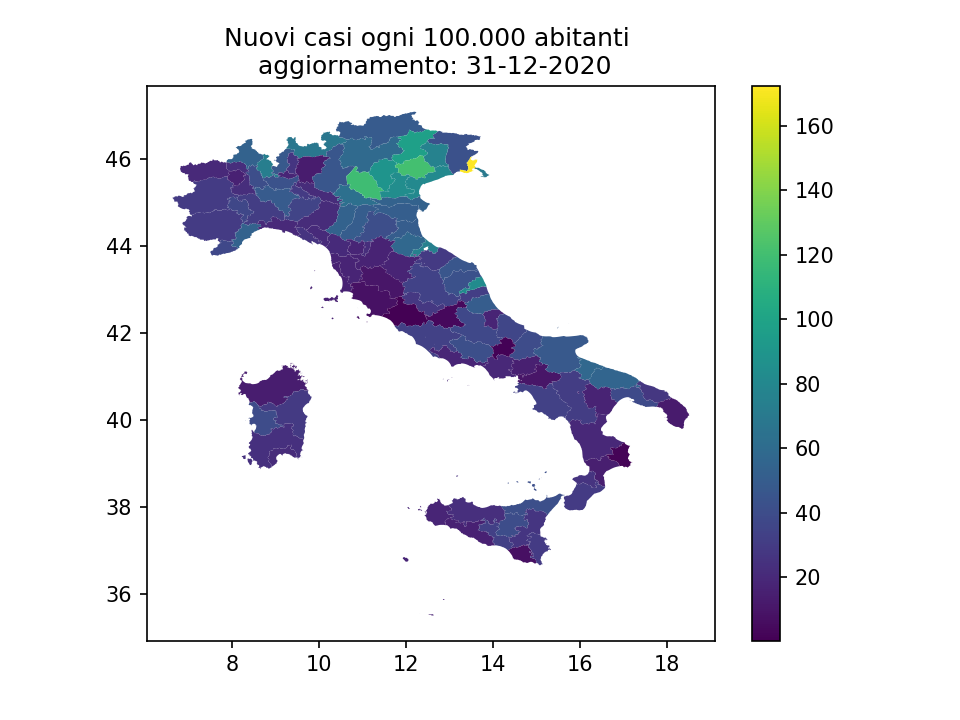

<IPython.core.display.Javascript object>


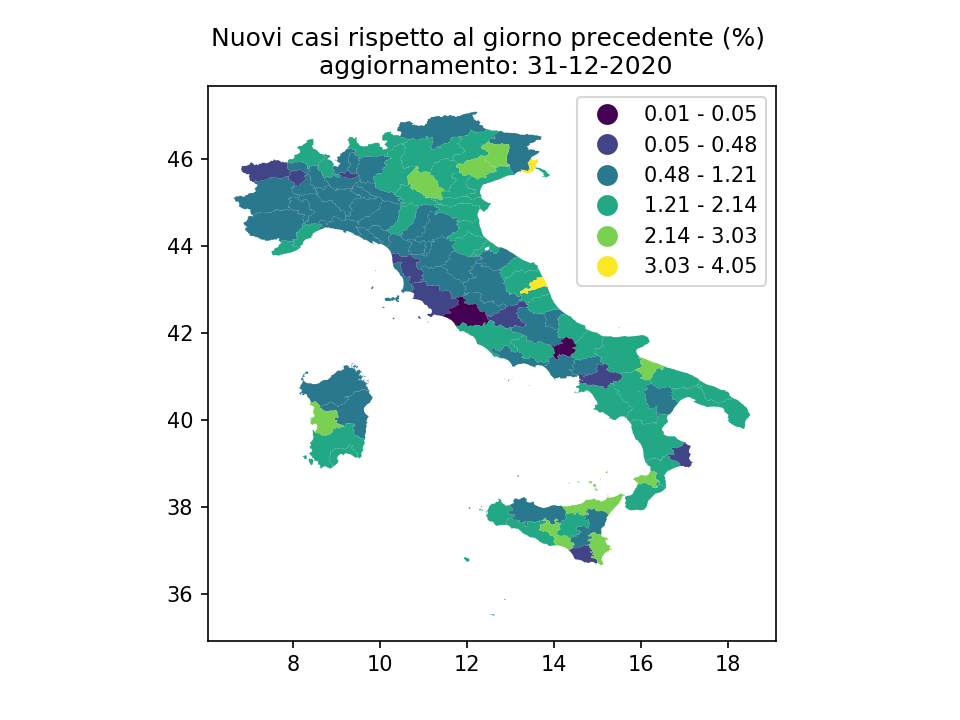

Text(0.5, 1.0, 'Nuovi casi rispetto al giorno precedente (%) \n aggiornamento: 31-12-2020')

In [7]:
date_ddmmyyyy = datech(dates[-1])
m.plot(column='nuovi_casi', legend=True)
plt.title(f'Nuovi casi Covid-19 \n aggiornamento: {date_ddmmyyyy}')

m.plot(column='nuovi_casi_100k', legend=True)
plt.title(f'Nuovi casi ogni 100.000 abitanti \n aggiornamento: {date_ddmmyyyy}')

#m.plot(column='var_perc_1day', legend=True, scheme='user_defined', classification_kwds={'bins':[25, 50, 75, 100]})
m.plot(column='var_perc_1day', legend=True, scheme='percentiles')
plt.title(f'Nuovi casi rispetto al giorno precedente (%) \n aggiornamento: {date_ddmmyyyy}')

#m.plot(column='casi_100k', legend=True)
#plt.title(f'Casi totali ogni 100.000 abitanti \n aggiornamento: {df.columns[-3]}')

# Andamento per Regioni

In [8]:
df = DF.pivot_table(index='denominazione_regione', columns='data', values='totale_casi', aggfunc=np.sum)
df['incremento'] = df[df.columns[-1]] - df[df.columns[-2]]
df = df.sort_values(['incremento', df.columns[-1]], ascending=[0, 0])
display(df[df.columns[-3:]])

data,2020-12-30T17:00:00,2020-12-31T17:00:00,incremento
denominazione_regione,,,
Veneto,249075,253875,4800
Lombardia,475044,478903,3859
Emilia-Romagna,169396,171512,2116
Lazio,161284,163051,1767
Puglia,89303,90964,1661
Campania,188119,189673,1554
Piemonte,196461,197828,1367
Sicilia,92345,93644,1299
Friuli Venezia Giulia,49150,50027,877


# Andamento per Province

In [9]:
df = DF.pivot_table(index=['sigla_provincia', 'denominazione_provincia'], columns='data', values='totale_casi', aggfunc=np.sum)
df['incremento'] = (df.iloc[:, -1] - df.iloc[:, -2])
df = df.sort_values(['incremento', df.columns[-2]], ascending=[0, 0]).reset_index()
df.index.rename('rank', inplace=True)
df.columns.rename('', inplace=True)
BRi = df.query('sigla_provincia=="BR"').index.values[0]
BSi = df.query('sigla_provincia=="BS"').index.values[0]
display(df.iloc[[0,1,2,3,4,5,6,7,8,9,10,11,12,BSi,BRi,-3,-2,-1], [1,-2,-1]])

,denominazione_provincia,2020-12-31T17:00:00,incremento
rank,,,
0,Roma,117378,1443
1,Milano,174013,1416
2,Verona,49675,1101
3,Treviso,49654,1072
4,Padova,46374,787
5,Vicenza,43116,771
6,Bari,35127,698
7,Venezia,38865,692
8,Torino,104188,676


<IPython.core.display.Javascript object>


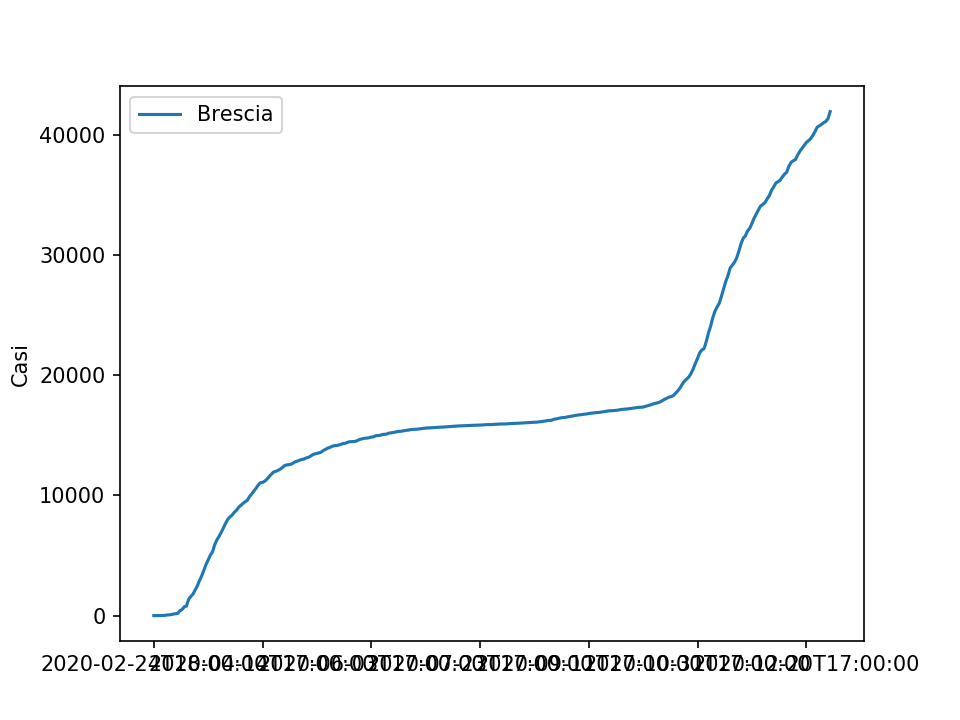

,sigla_provincia,denominazione_provincia,2020-02-24T18:00:00,2020-02-25T18:00:00,2020-02-26T18:00:00,2020-02-27T18:00:00,2020-02-28T18:00:00,2020-02-29T17:00:00,2020-03-01T17:00:00,2020-03-02T17:00:00,...,2020-12-23T17:00:00,2020-12-24T17:00:00,2020-12-25T17:00:00,2020-12-26T17:00:00,2020-12-27T17:00:00,2020-12-28T17:00:00,2020-12-29T17:00:00,2020-12-30T17:00:00,2020-12-31T17:00:00,incremento
rank,,,,,,,,,,,,,,,,,,,,,
10,BS,Brescia,0,0,2,10,13,14,49,60,...,39976,40286,40652,40783,40894,41039,41144,41370,41960,590


In [10]:
df[df['denominazione_provincia']=='Brescia'].T.iloc[2:-1].plot()
plt.legend(['Brescia'])
plt.ylabel('Casi')
display(df[df['denominazione_provincia']=='Brescia'])

# Regioni

In [11]:
reg_dir = data_dir /  'dati-regioni'
df = []
prec = lambda s: f'{s:.4f}'
for f in sorted(reg_dir.glob('dpc-covid19-ita-regioni-2020*.csv')):
    tmp_df = pd.read_csv(f, encoding='latin-1')
    df.append(tmp_df)
    del tmp_df
DF = pd.concat(df)

In [12]:
morti = DF.pivot_table(index='denominazione_regione', columns='data', values='deceduti').sum().to_numpy()
np.diff(morti)

array([  3,   2,   5,   4,   8,   5,  18,  27,  28,  41,  49,  36, 133,
        97, 168, 196, 189, 250, 175, 368, 349, 345, 475, 427, 627, 793,
       651, 601, 743, 683, 662, 969, 889, 756, 812, 837, 727, 760, 766,
       681, 525, 636, 604, 542, 610, 570, 619, 431, 566, 602, 578, 525,
       575, 482, 433, 454, 534, 437, 464, 420, 415, 260, 333, 382, 323,
       285, 269, 474, 174, 195, 236, 369, 274, 243, 194, 165, 179, 172,
       195, 262, 242, 153, 145,  99, 162, 161, 156, 130, 119,  50,  92,
        78, 117,  70,  87, 111,  75,  60,  55,  71,  88,  85,  72,  53,
        65,  79,  71,  53,  56,  78,  44,  26,  34,  43,  66,  47,  49,
        24,  23,  18, -31,  34,  30,   8,  22,   6,  23,  21,  30,  15,
        21,   7,   8,  30,  15,  12,  12,   7,   9,  13,  17,  13,  20,
        11,  14,   3,  13,  15,   9,  10,   5,   5,   5,   5,  11,   6,
         3,   9,   5,   8,  12,   5,  10,   6,   3,  13,   2,   4,   6,
        10,   6,   3, 158,   4,   4,   5,   7,   6,   9,   3,   

In [13]:
casi = DF.pivot_table(index='denominazione_regione', columns='data', values='totale_casi').sum()
np.diff(casi)

array([   93,    78,   250,   238,   240,   566,   342,   466,   587,
         769,   778,  1247,  1492,  1797,   977,  2313,  2651,  2547,
        3497,  3590,  3233,  3526,  4207,  5322,  5986,  6557,  5560,
        4789,  5249,  5210,  6153,  5959,  5974,  5217,  4050,  4053,
        4782,  4668,  4585,  4805,  4316,  3599,  3039,  3836,  4204,
        3951,  4694,  4092,  3153,  2972,  2667,  3786,  3493,  3491,
        3047,  2256,  2729,  3370,  2646,  3021,  2357,  2324,  1739,
        2091,  2086,  1872,  1965,  1900,  1389,  1221,  1075,  1444,
        1401,  1327,  1083,   802,   744,  1402,   888,   992,   789,
         875,   675,   451,   813,   665,   642,   652,   669,   531,
         300,   397,   584,   593,   516,   416,   355,   178,   318,
         321,   177,   518,   270,   197,   280,   283,   202,   379,
         163,   346,   338,   301,   210,   328,   331,  -148,   264,
         224,   221,   113,   577,   296,   255,   175,   174,   126,
         142,   182,

<IPython.core.display.Javascript object>


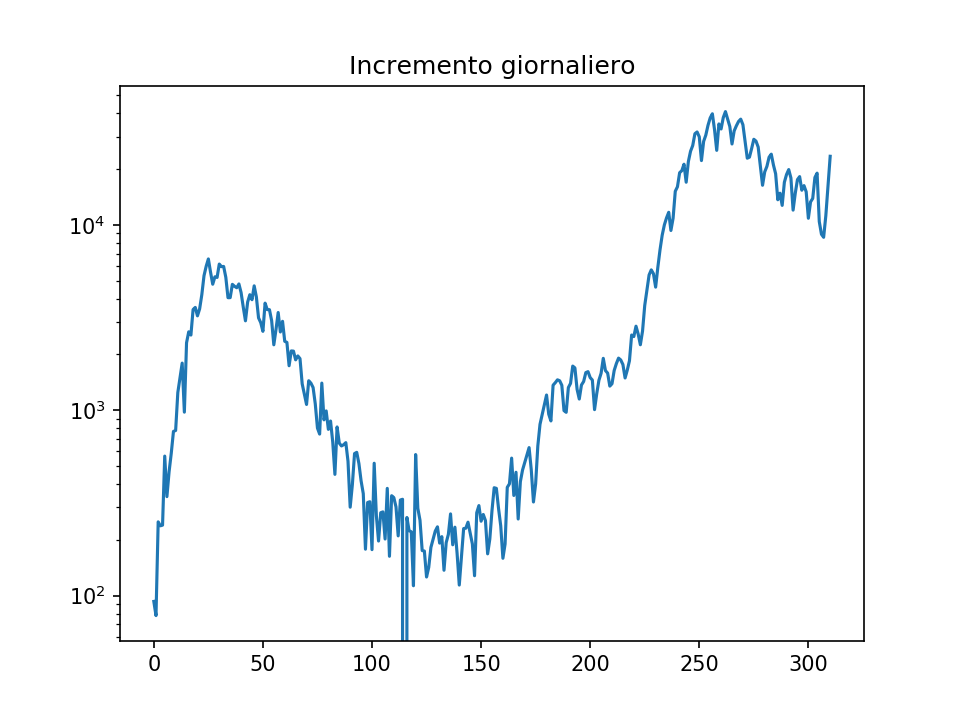

<IPython.core.display.Javascript object>


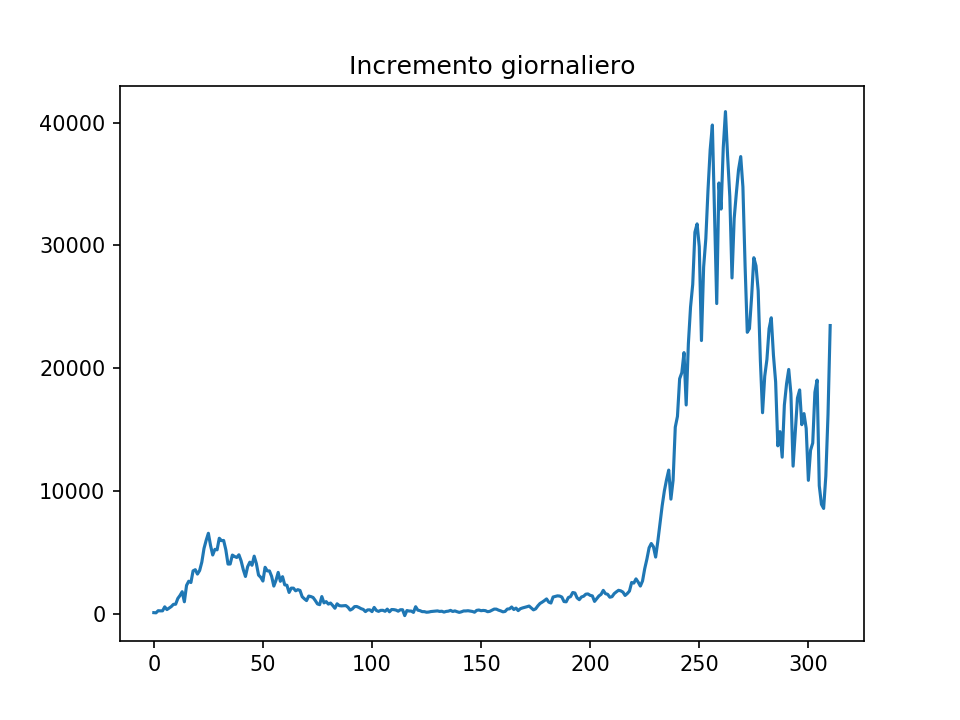

Text(0.5, 1.0, 'Incremento giornaliero')

In [14]:
plt.figure()
plt.semilogy(np.diff(casi))
plt.title('Incremento giornaliero')

plt.figure()
plt.plot(np.diff(casi))
plt.title('Incremento giornaliero')

# Dati Johns Hopkins
Data from [github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
# df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
# df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [16]:
df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '12/26/20', '12/27/20', '12/28/20', '12/29/20', '12/30/20', '12/31/20',
       '1/1/21', '1/2/21', '1/3/21', '1/4/21'],
      dtype='object', length=353)

<IPython.core.display.Javascript object>


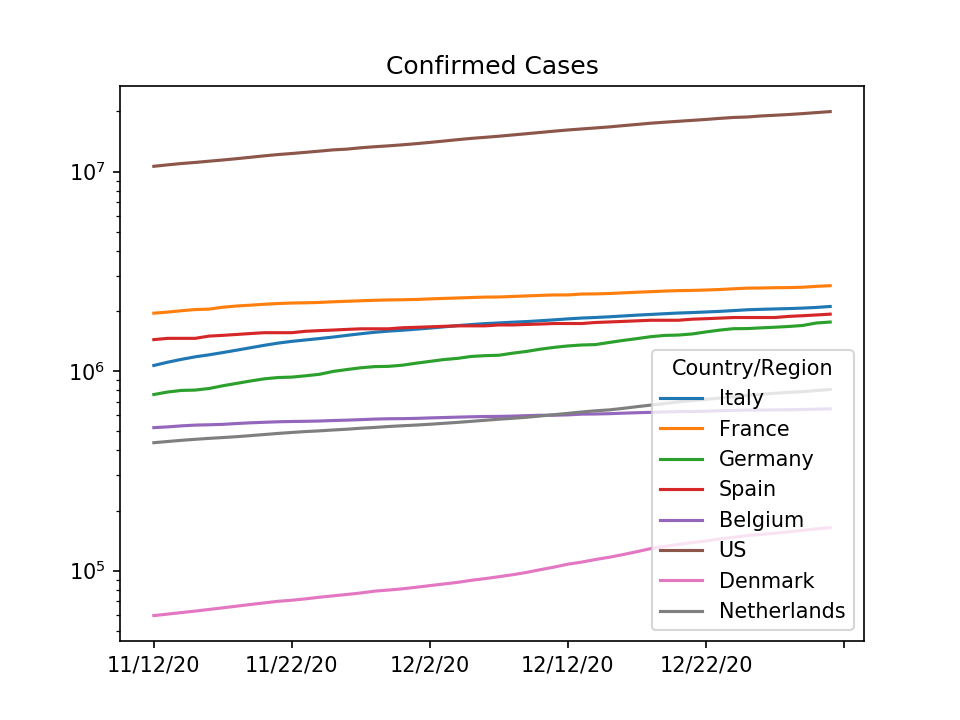

In [17]:
countries = ['Italy','France','Germany','Spain','Belgium', 'US', 'Denmark', 'Netherlands']
jhdates = [c for c in df.columns if '/20' in c]
df.groupby('Country/Region').sum().loc[countries][jhdates[-50:]].T.plot(logy=True, title='Confirmed Cases')

# Andamento Globale

In [18]:
df = df.groupby('Country/Region').sum().loc[countries][jhdates[-10:]]
df['increment'] = df.iloc[:, -1] - df.iloc[:, -2]
df = df.sort_values(['increment', df.columns[-1]], ascending=[0, 0])
display(df)

,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,increment
Country/Region,,,,,,,,,,,
US,18239758,18466484,18665343,18765529,18992126,19142603,19309281,19511426,19740772,19968087,227315
Italy,1977370,1991278,2009317,2028354,2038759,2047696,2056277,2067487,2083689,2107166,23477
France,2547577,2562615,2584333,2604595,2607688,2616510,2619616,2631110,2657624,2677666,20042
Germany,1570371,1604129,1630596,1632736,1646240,1658639,1672643,1692109,1741153,1760520,19367
Spain,1829903,1842289,1854951,1854951,1854951,1854951,1879413,1893502,1910218,1928265,18047
Netherlands,721429,731902,743493,755038,764907,774009,781467,789059,798592,808382,9790
Belgium,629109,632321,634904,637246,638030,638877,639734,641411,644242,646496,2254
Denmark,140750,144053,146927,149926,151764,153952,156434,159074,161862,164116,2254


# France

In [19]:
FR = pd.read_csv('https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv')

/user/lantelmi/home/Software/Python3/miniconda3/envs/torch-1.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
idx = ['DEP' in _ for _ in FR['maille_code']]
DEP = FR.loc[idx].pivot_table(index=['maille_code', 'maille_nom'], columns=['date'], values=['cas_confirmes']).droplevel(level=0, axis=1)
DEP.sum(1).sort_values(ascending=False).to_frame().iloc[:25]

,,0
maille_code,maille_nom,
DEP-68,Haut-Rhin,4106.000000
DEP-56,Morbihan,3405.000000
DEP-69,Rhône,3222.000000
DEP-13,Bouches-du-Rhône,3038.000000
DEP-74,Haute-Savoie,2830.333333
DEP-42,Loire,2009.000000
DEP-2A,Corse-du-Sud,1976.000000
DEP-44,Loire-Atlantique,1912.500000
DEP-67,Bas-Rhin,1876.000000


In [21]:
FR.columns.unique(
)

Index(['date', 'granularite', 'maille_code', 'maille_nom', 'cas_confirmes',
       'cas_ehpad', 'cas_confirmes_ehpad', 'cas_possibles_ehpad', 'deces',
       'deces_ehpad', 'reanimation', 'hospitalises',
       'nouvelles_hospitalisations', 'nouvelles_reanimations', 'gueris',
       'depistes', 'source_nom', 'source_url', 'source_archive',
       'source_type'],
      dtype='object')